# Read HCC splicing/unsplicing matrices

tutorial source: # https://dynamo-release.readthedocs.io/en/latest/notebooks/tutorial_pancreatic_endocrinogenesis.html

combine all HCC sample, then do the RNA velocity analysis

In [ ]:
import os
import scanpy as sc
import scvelo as scv
import numpy as np


#Read HCC splicing/unsplicing matrices

## HCC1
ldata1 = scv.read('scvelo_data/possorted_genome_bam_38RB4.loom', cache=False)
# rename barcodes in order to merge:
barcodes = [bc.split(':')[1] for bc in ldata1.obs.index.tolist()]
ldata1.obs.index = barcodes
ldata1.layers['spliced']

## HCC2
ldata2 = scv.read('scvelo_data/possorted_genome_bam_GIMO8.loom', cache=False)
# rename barcodes in order to merge:
barcodes = [bc.split(':')[1] for bc in ldata2.obs.index.tolist()]
ldata2.obs.index = barcodes
ldata2.layers['spliced']

## HCC3
ldata3 = scv.read('scvelo_data/possorted_genome_bam_OUUQ4.loom', cache=False)
# rename barcodes in order to merge:
barcodes = [bc.split(':')[1] for bc in ldata3.obs.index.tolist()]
ldata3.obs.index = barcodes
ldata3.layers['spliced']

## HCC4
ldata4 = scv.read('scvelo_data/possorted_genome_bam_YN3OB.loom', cache=False)
# rename barcodes in order to merge:
barcodes = [bc.split(':')[1] for bc in ldata4.obs.index.tolist()]
ldata4.obs.index = barcodes
ldata4.layers['spliced']

ldata4

#Combine all splicing data

# make variable names unique
ldata1.var_names_make_unique()
ldata2.var_names_make_unique()
ldata3.var_names_make_unique()
ldata4.var_names_make_unique()
# concatenate the three loom
ldata = ldata1.concatenate([ldata2, ldata3, ldata4])
ldata

ldata.obs
ldata.obs['batch'].index[0]

## Load all count matrix data
adata1 = sc.read_h5ad('scvelo_data/HCC4_anndata1.h5ad')
adata2 = sc.read_h5ad('scvelo_data/HCC4_anndata2.h5ad')
adata3 = sc.read_h5ad('scvelo_data/HCC4_anndata3.h5ad')
adata4 = sc.read_h5ad('scvelo_data/HCC4_anndata4.h5ad')

adata1.var_names_make_unique()
adata2.var_names_make_unique()
adata3.var_names_make_unique()
adata4.var_names_make_unique()
# concatenate the three loom
adata_all = adata1.concatenate([adata2, adata3, adata4])

adata_all

# merge matrices into the original adata object
adata = scv.utils.merge(adata_all, ldata)

# # find the missing spot
# missing_s = adata_all.obs['spot'][~adata_all.obs['spot'].isin(adata.obs['spot'])][0]
# # dfObj.drop('b')
# missing_s
for i in range(adata.shape[0]):
    if adata_all.obs['spot'][i]!=adata.obs['spot'][i]:
        break
missing_s = adata_all.obs['spot'][i]
print(missing_s)
missing_ind = np.where(adata4.obs['spot']==missing_s)
adata4 = adata4.obs.drop(index=missing_s)

## Read low-dimensional embeddings and clusters from iDR-SC 
import pyreadr
os.chdir("/home/xuliao/LiuWei/HCC4Data")
hZ_data =  pyreadr.read_r('hZList_idrssc.rds')
hZ = np.array(hZ_data['hZ_idrsc_HCC1'])
for i in range(4-1):
    hZ = np.concatenate((hZ, hZ_data['hZ_idrsc_HCC'+str(i+2)]))
hZ_new = np.delete(hZ, (missing_ind), axis=0)
cluster_data = pyreadr.read_r('hcc_cluster.rds')
cluster = np.array(cluster_data['cluster_hcc1'])
for i in range(4-1):
    cluster = np.concatenate((cluster, cluster_data['cluster_hcc'+str(i+2)]))
cluster_new = np.delete(cluster, (missing_ind), axis=0)
cluster_dr = cluster_new.copy()
cluster_dr[cluster_new == 3] = 1
cluster_dr[cluster_new == 8] = 2
cluster_dr[cluster_new == 9] = 3
cluster_dr[cluster_new == 7] = 4
cluster_dr[cluster_new == 1] = 5
cluster_dr[cluster_new == 5] = 6
cluster_dr[cluster_new == 6] = 7
cluster_dr[cluster_new == 4] = 8
cluster_dr[cluster_new == 2] = 9
cluster_dr
adata.obsm["Z"] = hZ_new
adata.obs["cluster"] = cluster_dr
adata.obs["clusters"] = cluster_dr
adata

# adata.var['gene_id']
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
selected_clust = (cluster_dr < 6)
adata = adata[selected_clust]

# Scvelo computation

In [2]:
# scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000) 
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)
# selected_clust = (cluster_dr < 6)
# adata = adata[selected_clust]

scv.tl.velocity(adata, mode='steady_state')

scv.tl.recover_dynamics(adata)

scv.tl.velocity(adata, mode='dynamical')

scv.tl.velocity_graph(adata)

scv.tl.recover_latent_time(adata)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:39) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 1/40 cores)


  0%|          | 0/94 [00:00<?, ?gene/s]

    finished (0:08:09) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:11) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/40 cores)


  0%|          | 0/7888 [00:00<?, ?cells/s]

    finished (0:00:31) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 2 regions of end points .
    finished (0:00:06) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:05) --> added 
    'latent_time', shared time (adata.obs)


# Draw heatmaps with top genes

ranking velocity genes
    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
saving figure to file ./figures/scvelo_heatmap_scvelo_heatmap.png


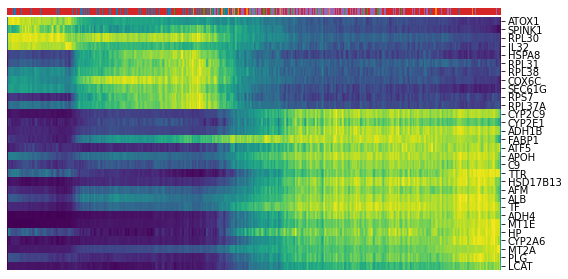

In [5]:
import seaborn as sns
scv.tl.rank_velocity_genes(adata, groupby='clusters', min_corr=.3)
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[0:30]
# sc.pp.log1p(adata)
p = scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='clusters',
                   palette = ["#CB181D", "#EF3B2C", "#FB6A4A", "#FC9272", "#FCBBA1"],
                   save='scvelo_heatmap.png',colorbar=True,row_cluster=False, n_convolve=30, yticklabels=True)
# p = scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='clusters',
#                    palette = ["#CB181D", "#EF3B2C", "#FB6A4A", "#FC9272", "#FCBBA1", "#1f77b4", "#A65628",  "blue", "#00ee00"],
#                    save='scvelo_heatmap.png',colorbar=True,row_cluster=False, n_convolve=30,yticklabels=True)